In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import csv
import numpy as np
import pandas as pd
import os
from collections import Counter

# Required RDKit modules
import rdkit as rd
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import RDConfig
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.rdMolDescriptors import GetAtomPairFingerprint
from rdkit.Chem.AtomPairs import Torsions
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import rdMolDescriptors

# modeling
import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import xgboost

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
frame = PandasTools.LoadSDF('fda_stok.sdf',smilesName='SMILES',molColName='Molecule', includeFingerprints=True)
frame = frame.drop(['ID', 'Molecule', 'smiles'], axis=1)

In [4]:
frame["mol"] = [Chem.MolFromSmiles(x) for x in frame["SMILES"]]

,zinc_id,SMILES,mol
0,ZINC000001530427,C[C@@H]1O[C@@H]1P(=O)(O)O,
1,ZINC000003807804,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,
2,ZINC000000120286,Nc1nc(N)c2nc(-c3ccccc3)c(N)nc2n1,
3,ZINC000242548690,C[C@H]1O[C@@H](O[C@H]2[C@@H](O)C[C@H](O[C@H]3[...,
4,ZINC000000008492,Oc1cccc2cccnc12,
...,...,...,...
1610,ZINC000022010387,C[C@H]1[C@H](c2ccccc2)OCCN1C,
1611,ZINC000022448097,CCOc1ccc(C[C@@H](CN(CCN(CC(=O)O)CC(=O)O)CC(=O)...,
1612,ZINC000100370145,CC1(C)[C@H]2CC[C@@]1(CS(=O)(=O)O)C(=O)/C2=C/c1...,
1613,ZINC000059111167,[C-]#[N+]CC(C)(C)OC,

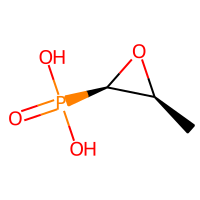
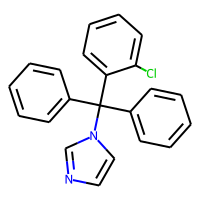
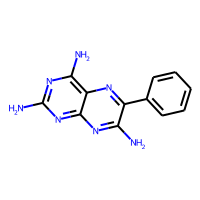
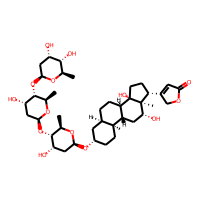
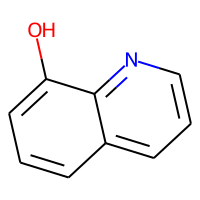
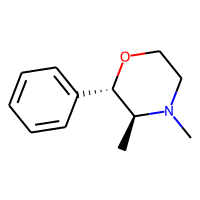
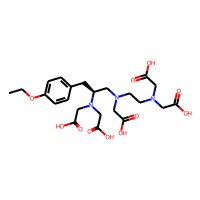
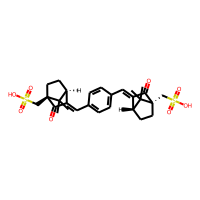
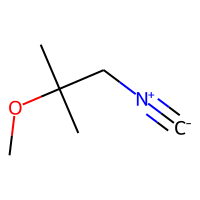
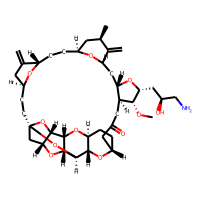

In [5]:
frame

In [6]:
fingerprints = pd.DataFrame()
fingerprints["morgan"] = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits = 2048) for m in frame['mol']]
fingerprints["daylight"] = [Chem.RDKFingerprint(m) for m in frame["mol"]]
fingerprints["atompair"] = [Chem.GetHashedAtomPairFingerprintAsBitVect(m) for m in frame["mol"]]
fingerprints["torsion"] = torsion_fp = [Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(m) for m in frame["mol"]]

In [8]:
fingerprints

,morgan,daylight,atompair,torsion,desc
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.517285418866277, 138.21884910034808, 74.656..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[2.153583648156872, 908.2706613028778, 1236605..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[2.3078316699480332, 754.8677985188037, 27245...."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, ...","[1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.8374981988041248, 1409.0037418555949, 14643..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.9131611636048604, 378.7244463345712, 505.76..."
...,...,...,...,...,...
1610,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[2.174499247830223, 285.6330203302586, 2171.55..."
1611,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3.20519718581977, 891.0175363739821, 42747274..."
1612,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.437782126757885, 1397.3474102675675, 138191..."
1613,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3.5806290680599435, 101.58638780895905, 41.81..."



# CHEMICAL SIMILARITY

In [72]:
def findMostLike(fileName, k=10):
    drug = Chem.MolFromPDBFile(fileName)
    fp_ref = Chem.RDKFingerprint(drug)
    fda = Chem.SDMolSupplier('fda_stok.sdf')
    fingerprints = [Chem.RDKFingerprint(m) for m in fda]
    sim = [DataStructs.TanimotoSimilarity(fp_ref,fp) for fp in fingerprints]
    index = np.argsort(sim)[-k:]
    return frame.iloc[index,:], [sim[i] for i in index]

In [73]:
def findMostLikeMG(fileName,radius=1, nBits=2048, useChirality=True, k=10):
    drug = Chem.MolFromPDBFile(fileName)
    fp_ref = Chem.GetMorganFingerprintAsBitVect(drug, radius=radius,
                                                        nBits=nBits,
                                                        useChirality=useChirality)
    fda = Chem.SDMolSupplier('fda_stok.sdf')
    fingerprints = [Chem.GetMorganFingerprintAsBitVect(m, radius=radius,
                                                        nBits=nBits,
                                                        useChirality=useChirality) for m in fda]
    sim = [DataStructs.TanimotoSimilarity(fp_ref,fp) for fp in fingerprints]
    index = np.argsort(sim)[-k:]
    return frame.iloc[index,:], [sim[i] for i in index]

In [74]:
def findMostLikeAP(fileName, k=10):
    drug = Chem.MolFromPDBFile(fileName)
    fp_ref = Chem.GetHashedAtomPairFingerprintAsBitVect(drug)
    fda = Chem.SDMolSupplier('fda_stok.sdf')
    fingerprints = [Chem.GetHashedAtomPairFingerprintAsBitVect(m) for m in fda]
    sim = [DataStructs.TanimotoSimilarity(fp_ref,fp) for fp in fingerprints]
    index = np.argsort(sim)[-k:]
    return frame.iloc[index,:]

In [75]:
def findMostLikeTorsion(fileName, k=10):
    drug = Chem.MolFromPDBFile(fileName)
    fp_ref = Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(drug)
    fda = Chem.SDMolSupplier('fda_stok.sdf')
    fingerprints = [Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(m) for m in fda]
    sim = [DataStructs.TanimotoSimilarity(fp_ref,fp) for fp in fingerprints]
    index = np.argsort(sim)[-k:]
    return frame.iloc[index,:]

,zinc_id,SMILES,mol
272,ZINC000026664090,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...,
430,ZINC000003914596,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...,
119,ZINC000029416466,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...,
96,ZINC000052955754,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
285,ZINC000203686879,COC[C@H]1C[C@@H](c2ncc(-c3ccc4c(c3)COc3cc5c(cc...,
909,ZINC000003978005,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
1552,ZINC000150601177,COC(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1ccc([C@@...,
763,ZINC000150338819,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1ncc(-c2c...,
165,ZINC000068204830,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2ccc(-c3...,
50,ZINC000150588351,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2...,

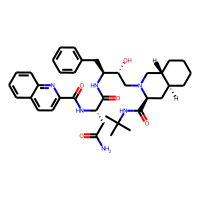
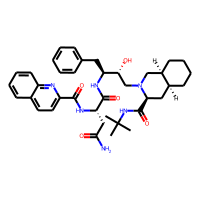
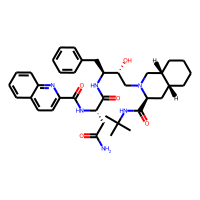
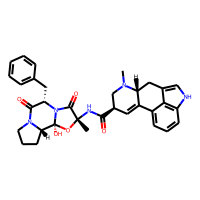
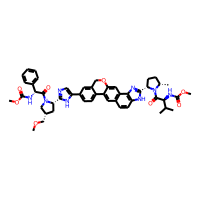
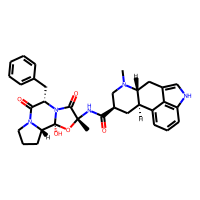
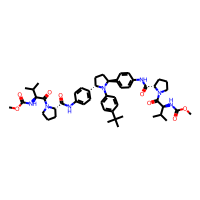
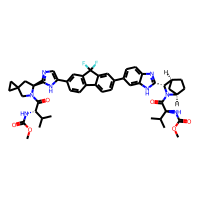
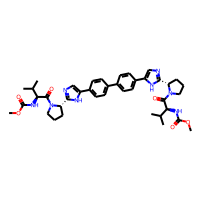
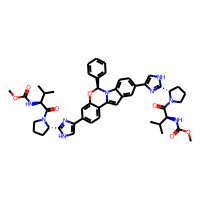

In [76]:
findMostLikeTorsion('DRI-C21041.pdb')

,zinc_id,SMILES,mol
274,ZINC000026985532,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...,
272,ZINC000026664090,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...,
430,ZINC000003914596,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...,
119,ZINC000029416466,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...,
285,ZINC000203686879,COC[C@H]1C[C@@H](c2ncc(-c3ccc4c(c3)COc3cc5c(cc...,
1552,ZINC000150601177,COC(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1ccc([C@@...,
909,ZINC000003978005,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
165,ZINC000068204830,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2ccc(-c3...,
763,ZINC000150338819,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1ncc(-c2c...,
50,ZINC000150588351,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2...,

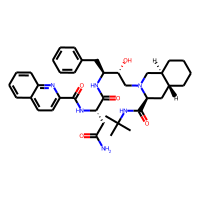
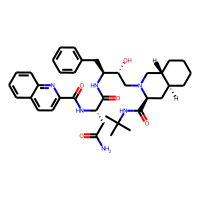
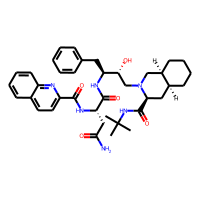
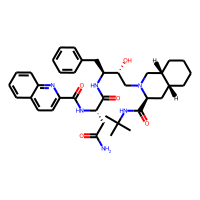
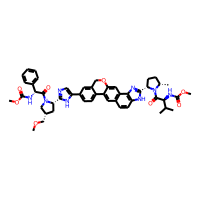
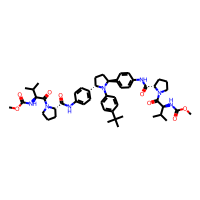
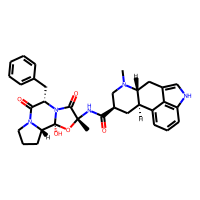
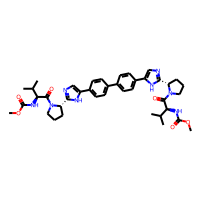
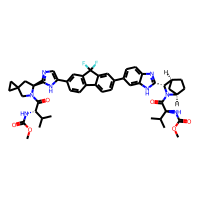
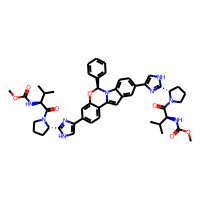

In [77]:
findMostLikeTorsion('DRI-C23041.pdb')

,zinc_id,SMILES,mol
272,ZINC000026664090,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...,
119,ZINC000029416466,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...,
430,ZINC000003914596,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...,
285,ZINC000203686879,COC[C@H]1C[C@@H](c2ncc(-c3ccc4c(c3)COc3cc5c(cc...,
96,ZINC000052955754,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
763,ZINC000150338819,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1ncc(-c2c...,
1552,ZINC000150601177,COC(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1ccc([C@@...,
909,ZINC000003978005,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
165,ZINC000068204830,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2ccc(-c3...,
50,ZINC000150588351,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2...,

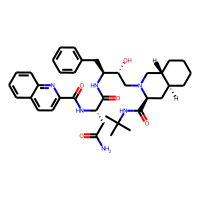
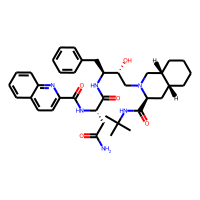
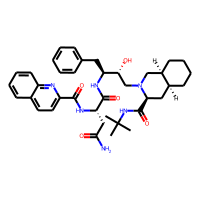
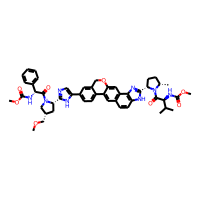
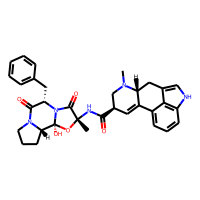
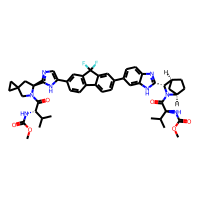
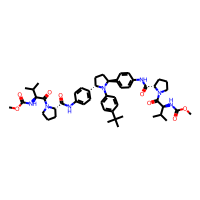
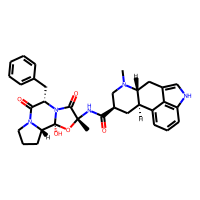
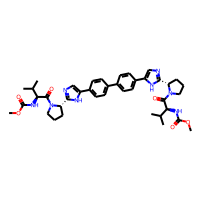
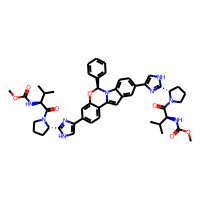

In [78]:
findMostLikeTorsion('DRI-C24041.pdb')

,zinc_id,SMILES,mol
274,ZINC000026985532,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...,
272,ZINC000026664090,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...,
119,ZINC000029416466,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...,
96,ZINC000052955754,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
285,ZINC000203686879,COC[C@H]1C[C@@H](c2ncc(-c3ccc4c(c3)COc3cc5c(cc...,
909,ZINC000003978005,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
1552,ZINC000150601177,COC(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1ccc([C@@...,
763,ZINC000150338819,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1ncc(-c2c...,
165,ZINC000068204830,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2ccc(-c3...,
50,ZINC000150588351,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2...,

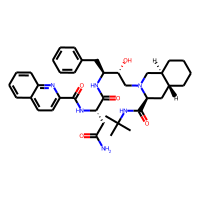
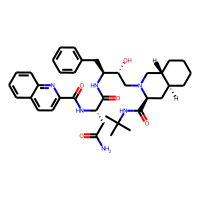
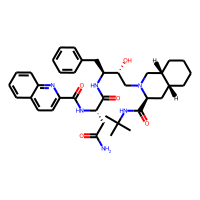
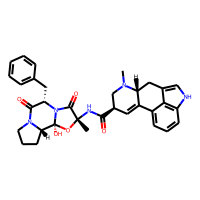
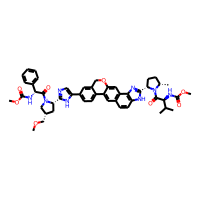
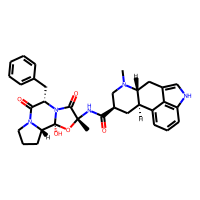
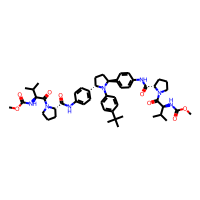
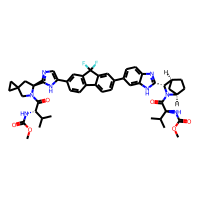
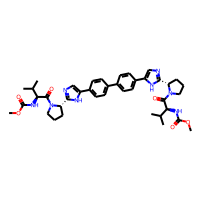
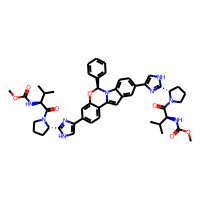

In [79]:
findMostLikeTorsion('DRI-C61041.pdb')

,zinc_id,SMILES,mol
430,ZINC000003914596,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...,
274,ZINC000026985532,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...,
272,ZINC000026664090,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...,
96,ZINC000052955754,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
285,ZINC000203686879,COC[C@H]1C[C@@H](c2ncc(-c3ccc4c(c3)COc3cc5c(cc...,
909,ZINC000003978005,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
1552,ZINC000150601177,COC(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1ccc([C@@...,
763,ZINC000150338819,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1ncc(-c2c...,
165,ZINC000068204830,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2ccc(-c3...,
50,ZINC000150588351,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2...,

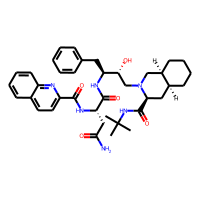
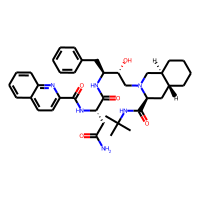
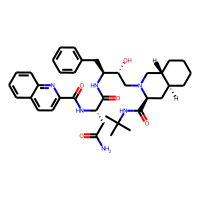
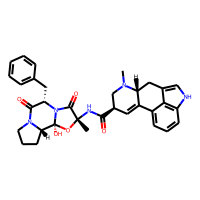
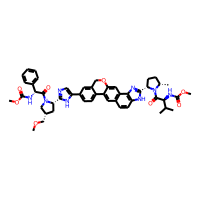
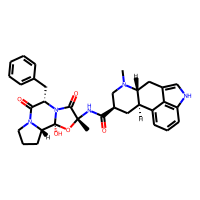
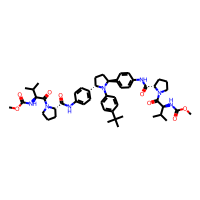
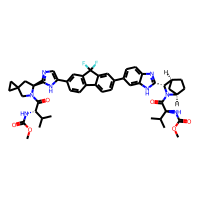
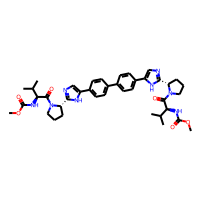
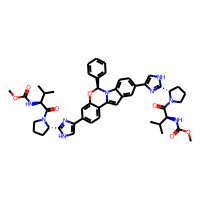

In [80]:
findMostLikeTorsion('DRI-C71041.pdb')

,zinc_id,SMILES,mol
119,ZINC000029416466,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...,
274,ZINC000026985532,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...,
272,ZINC000026664090,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...,
430,ZINC000003914596,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...,
909,ZINC000003978005,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
285,ZINC000203686879,COC[C@H]1C[C@@H](c2ncc(-c3ccc4c(c3)COc3cc5c(cc...,
1552,ZINC000150601177,COC(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1ccc([C@@...,
165,ZINC000068204830,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2ccc(-c3...,
763,ZINC000150338819,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1ncc(-c2c...,
50,ZINC000150588351,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2...,

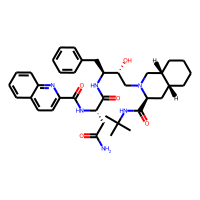
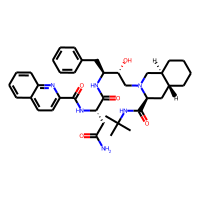
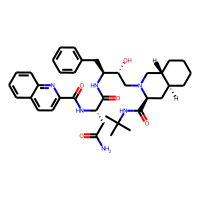
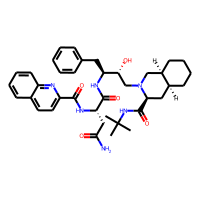
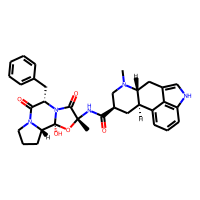
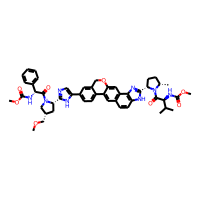
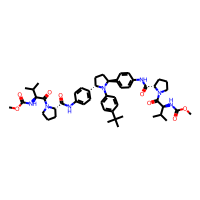
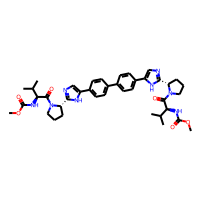
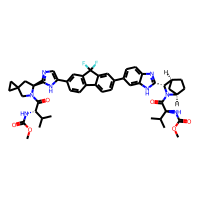
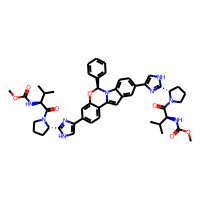

In [81]:
findMostLikeTorsion('DRI-C91005.pdb')

,zinc_id,SMILES,mol
119,ZINC000029416466,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...,
430,ZINC000003914596,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...,
272,ZINC000026664090,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...,
274,ZINC000026985532,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...,
285,ZINC000203686879,COC[C@H]1C[C@@H](c2ncc(-c3ccc4c(c3)COc3cc5c(cc...,
909,ZINC000003978005,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
1552,ZINC000150601177,COC(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1ccc([C@@...,
165,ZINC000068204830,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2ccc(-c3...,
763,ZINC000150338819,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1ncc(-c2c...,
50,ZINC000150588351,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2...,

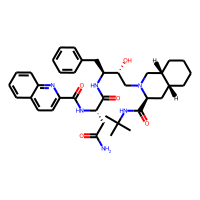
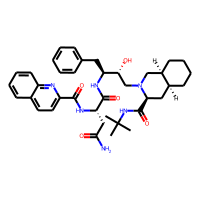
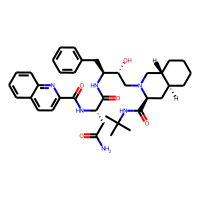
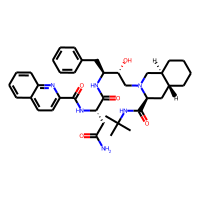
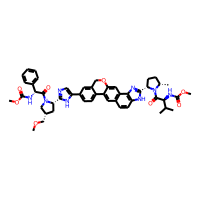
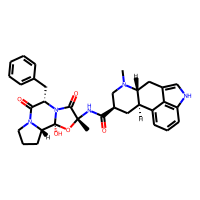
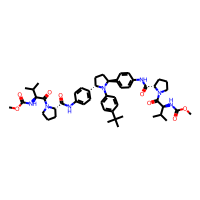
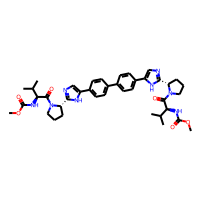
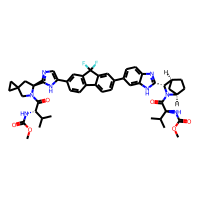
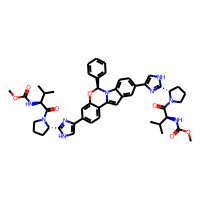

In [82]:
findMostLikeTorsion('DRI-C2204745.pdb')

,zinc_id,SMILES,mol
272,ZINC000026664090,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...,
274,ZINC000026985532,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...,
430,ZINC000003914596,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...,
96,ZINC000052955754,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
909,ZINC000003978005,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
285,ZINC000203686879,COC[C@H]1C[C@@H](c2ncc(-c3ccc4c(c3)COc3cc5c(cc...,
1552,ZINC000150601177,COC(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1ccc([C@@...,
763,ZINC000150338819,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1ncc(-c2c...,
165,ZINC000068204830,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2ccc(-c3...,
50,ZINC000150588351,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2...,

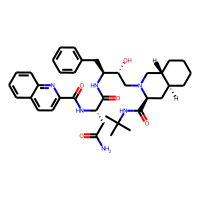
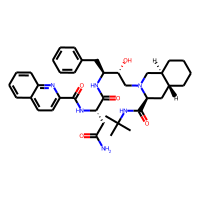
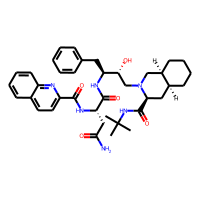
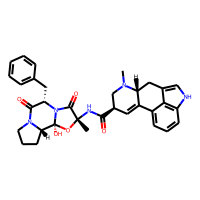
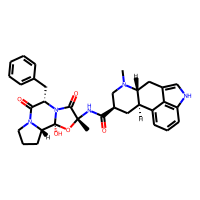
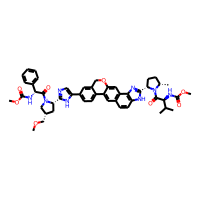
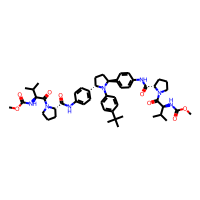
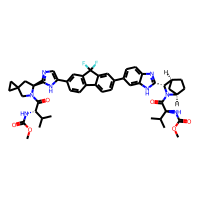
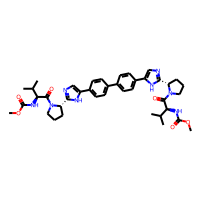
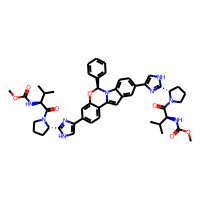

In [83]:
findMostLikeTorsion('Erythrosine B.pdb ')

,zinc_id,SMILES,mol
430,ZINC000003914596,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...,
272,ZINC000026664090,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...,
274,ZINC000026985532,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...,
119,ZINC000029416466,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...,
909,ZINC000003978005,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
285,ZINC000203686879,COC[C@H]1C[C@@H](c2ncc(-c3ccc4c(c3)COc3cc5c(cc...,
1552,ZINC000150601177,COC(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1ccc([C@@...,
165,ZINC000068204830,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2ccc(-c3...,
763,ZINC000150338819,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1ncc(-c2c...,
50,ZINC000150588351,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2...,

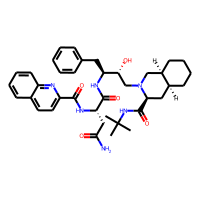
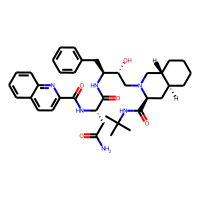
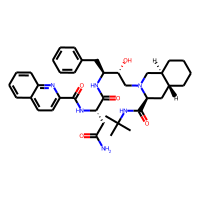
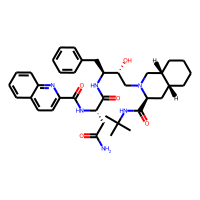
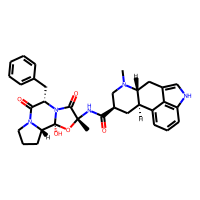
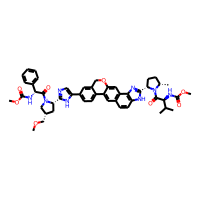
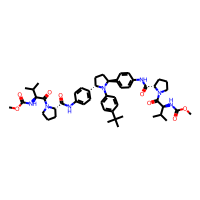
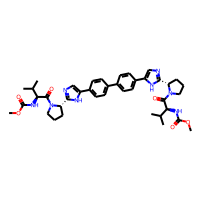
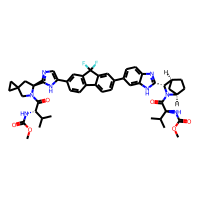
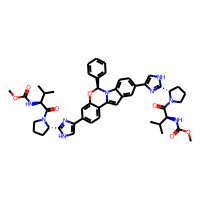

In [84]:
findMostLikeTorsion('Methylene Blue.pdb')

In [85]:
findMostLike('DRI-C21041.pdb')

(               zinc_id                                             SMILES  \
 1354  ZINC000169621215  CO[C@H]1/C=C\O[C@@]2(C)Oc3c(C)c(O)c4c(c3C2=O)C...   
 415   ZINC000100378061  CC(C)(NC(=O)C1=C(O)[C@@H]2Oc3c(O)ccc4c3[C@@]23...   
 1596  ZINC000150338708  COc1cc2c(cc1O)CCN[C@]21CS[C@@H]2c3c(OC(C)=O)c(...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 987   ZINC000087496429  CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(...   
 1356  ZINC000085555528  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 1437  ZINC000085432544  CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...   
 631   ZINC000085432549  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 
                                                     mol  
 1354  <img data-content="rdkit/molecule" src="data:i...  
 415   <img data-conte

In [86]:
findMostLike('DRI-C23041.pdb')

(               zinc_id                                             SMILES  \
 1354  ZINC000169621215  CO[C@H]1/C=C\O[C@@]2(C)Oc3c(C)c(O)c4c(c3C2=O)C...   
 415   ZINC000100378061  CC(C)(NC(=O)C1=C(O)[C@@H]2Oc3c(O)ccc4c3[C@@]23...   
 1596  ZINC000150338708  COc1cc2c(cc1O)CCN[C@]21CS[C@@H]2c3c(OC(C)=O)c(...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 987   ZINC000087496429  CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(...   
 1356  ZINC000085555528  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 1437  ZINC000085432544  CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...   
 631   ZINC000085432549  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 
                                                     mol  
 1354  <img data-content="rdkit/molecule" src="data:i...  
 415   <img data-conte

In [87]:
findMostLike('DRI-C24041.pdb')

(               zinc_id                                             SMILES  \
 1354  ZINC000169621215  CO[C@H]1/C=C\O[C@@]2(C)Oc3c(C)c(O)c4c(c3C2=O)C...   
 1596  ZINC000150338708  COc1cc2c(cc1O)CCN[C@]21CS[C@@H]2c3c(OC(C)=O)c(...   
 415   ZINC000100378061  CC(C)(NC(=O)C1=C(O)[C@@H]2Oc3c(O)ccc4c3[C@@]23...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 987   ZINC000087496429  CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(...   
 1437  ZINC000085432544  CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...   
 1356  ZINC000085555528  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 631   ZINC000085432549  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 
                                                     mol  
 1354  <img data-content="rdkit/molecule" src="data:i...  
 1596  <img data-conte

In [88]:
findMostLike('DRI-C61041.pdb')

(               zinc_id                                             SMILES  \
 1354  ZINC000169621215  CO[C@H]1/C=C\O[C@@]2(C)Oc3c(C)c(O)c4c(c3C2=O)C...   
 415   ZINC000100378061  CC(C)(NC(=O)C1=C(O)[C@@H]2Oc3c(O)ccc4c3[C@@]23...   
 1596  ZINC000150338708  COc1cc2c(cc1O)CCN[C@]21CS[C@@H]2c3c(OC(C)=O)c(...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 987   ZINC000087496429  CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(...   
 1356  ZINC000085555528  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 1437  ZINC000085432544  CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...   
 631   ZINC000085432549  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 
                                                     mol  
 1354  <img data-content="rdkit/molecule" src="data:i...  
 415   <img data-conte

In [89]:
findMostLike('DRI-C71041.pdb')

(               zinc_id                                             SMILES  \
 1354  ZINC000169621215  CO[C@H]1/C=C\O[C@@]2(C)Oc3c(C)c(O)c4c(c3C2=O)C...   
 415   ZINC000100378061  CC(C)(NC(=O)C1=C(O)[C@@H]2Oc3c(O)ccc4c3[C@@]23...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 1596  ZINC000150338708  COc1cc2c(cc1O)CCN[C@]21CS[C@@H]2c3c(OC(C)=O)c(...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 987   ZINC000087496429  CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(...   
 1437  ZINC000085432544  CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...   
 1356  ZINC000085555528  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 631   ZINC000085432549  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 
                                                     mol  
 1354  <img data-content="rdkit/molecule" src="data:i...  
 415   <img data-conte

In [90]:
findMostLike('DRI-C91005.pdb')

(               zinc_id                                             SMILES  \
 1354  ZINC000169621215  CO[C@H]1/C=C\O[C@@]2(C)Oc3c(C)c(O)c4c(c3C2=O)C...   
 415   ZINC000100378061  CC(C)(NC(=O)C1=C(O)[C@@H]2Oc3c(O)ccc4c3[C@@]23...   
 1596  ZINC000150338708  COc1cc2c(cc1O)CCN[C@]21CS[C@@H]2c3c(OC(C)=O)c(...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 987   ZINC000087496429  CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(...   
 1356  ZINC000085555528  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 1437  ZINC000085432544  CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...   
 631   ZINC000085432549  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 
                                                     mol  
 1354  <img data-content="rdkit/molecule" src="data:i...  
 415   <img data-conte

In [91]:
findMostLike('DRI-C2204745.pdb')

(               zinc_id                                             SMILES  \
 1354  ZINC000169621215  CO[C@H]1/C=C\O[C@@]2(C)Oc3c(C)c(O)c4c(c3C2=O)C...   
 415   ZINC000100378061  CC(C)(NC(=O)C1=C(O)[C@@H]2Oc3c(O)ccc4c3[C@@]23...   
 1596  ZINC000150338708  COc1cc2c(cc1O)CCN[C@]21CS[C@@H]2c3c(OC(C)=O)c(...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 987   ZINC000087496429  CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(...   
 1437  ZINC000085432544  CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...   
 1356  ZINC000085555528  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 631   ZINC000085432549  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 
                                                     mol  
 1354  <img data-content="rdkit/molecule" src="data:i...  
 415   <img data-conte

In [92]:
findMostLike('Erythrosine B.pdb ')

(               zinc_id                                             SMILES  \
 1354  ZINC000169621215  CO[C@H]1/C=C\O[C@@]2(C)Oc3c(C)c(O)c4c(c3C2=O)C...   
 415   ZINC000100378061  CC(C)(NC(=O)C1=C(O)[C@@H]2Oc3c(O)ccc4c3[C@@]23...   
 1596  ZINC000150338708  COc1cc2c(cc1O)CCN[C@]21CS[C@@H]2c3c(OC(C)=O)c(...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 987   ZINC000087496429  CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(...   
 1356  ZINC000085555528  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 1437  ZINC000085432544  CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...   
 631   ZINC000085432549  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 
                                                     mol  
 1354  <img data-content="rdkit/molecule" src="data:i...  
 415   <img data-conte

In [93]:
findMostLike('Methylene Blue.pdb')

(               zinc_id                                             SMILES  \
 1354  ZINC000169621215  CO[C@H]1/C=C\O[C@@]2(C)Oc3c(C)c(O)c4c(c3C2=O)C...   
 1596  ZINC000150338708  COc1cc2c(cc1O)CCN[C@]21CS[C@@H]2c3c(OC(C)=O)c(...   
 415   ZINC000100378061  CC(C)(NC(=O)C1=C(O)[C@@H]2Oc3c(O)ccc4c3[C@@]23...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 987   ZINC000087496429  CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(...   
 1356  ZINC000085555528  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 1437  ZINC000085432544  CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...   
 631   ZINC000085432549  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 
                                                     mol  
 1354  <img data-content="rdkit/molecule" src="data:i...  
 1596  <img data-conte

In [94]:
findMostLikeMG('DRI-C21041.pdb')

(               zinc_id                                             SMILES  \
 513   ZINC000003951740  Cc1cccc(C)c1OCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)...   
 1238  ZINC000003791297  CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[...   
 1264  ZINC000003807172  C[C@H]1CNc2c(cccc2S(=O)(=O)N[C@@H](CCCNC(=N)N)...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 881   ZINC000095619105  CC[C@@H](CO)NC(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 272   ZINC000026664090  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...   
 274   ZINC000026985532  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...   
 119   ZINC000029416466  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...   
 430   ZINC000003914596  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...   
 
                                                     mol  
 513   <img data-content="rdkit/molecule" src="data:i...  
 1238  <img data-conte

In [95]:
findMostLikeMG('DRI-C23041.pdb')

(               zinc_id                                             SMILES  \
 1238  ZINC000003791297  CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 881   ZINC000095619105  CC[C@@H](CO)NC(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 1264  ZINC000003807172  C[C@H]1CNc2c(cccc2S(=O)(=O)N[C@@H](CCCNC(=N)N)...   
 272   ZINC000026664090  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...   
 274   ZINC000026985532  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...   
 430   ZINC000003914596  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...   
 119   ZINC000029416466  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...   
 
                                                     mol  
 1238  <img data-content="rdkit/molecule" src="data:i...  
 96    <img data-conte

In [96]:
findMostLikeMG('DRI-C24041.pdb')

(               zinc_id                                             SMILES  \
 513   ZINC000003951740  Cc1cccc(C)c1OCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)...   
 1238  ZINC000003791297  CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[...   
 1264  ZINC000003807172  C[C@H]1CNc2c(cccc2S(=O)(=O)N[C@@H](CCCNC(=N)N)...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 881   ZINC000095619105  CC[C@@H](CO)NC(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 272   ZINC000026664090  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...   
 274   ZINC000026985532  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...   
 119   ZINC000029416466  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...   
 430   ZINC000003914596  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...   
 
                                                     mol  
 513   <img data-content="rdkit/molecule" src="data:i...  
 1238  <img data-conte

In [97]:
findMostLikeMG('DRI-C61041.pdb')

(               zinc_id                                             SMILES  \
 513   ZINC000003951740  Cc1cccc(C)c1OCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)...   
 1238  ZINC000003791297  CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 881   ZINC000095619105  CC[C@@H](CO)NC(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 274   ZINC000026985532  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...   
 272   ZINC000026664090  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...   
 1264  ZINC000003807172  C[C@H]1CNc2c(cccc2S(=O)(=O)N[C@@H](CCCNC(=N)N)...   
 430   ZINC000003914596  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...   
 119   ZINC000029416466  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...   
 
                                                     mol  
 513   <img data-content="rdkit/molecule" src="data:i...  
 1238  <img data-conte

In [98]:
findMostLikeMG('DRI-C71041.pdb')

(               zinc_id                                             SMILES  \
 513   ZINC000003951740  Cc1cccc(C)c1OCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)...   
 1238  ZINC000003791297  CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[...   
 1264  ZINC000003807172  C[C@H]1CNc2c(cccc2S(=O)(=O)N[C@@H](CCCNC(=N)N)...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 881   ZINC000095619105  CC[C@@H](CO)NC(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 274   ZINC000026985532  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...   
 272   ZINC000026664090  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...   
 430   ZINC000003914596  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...   
 119   ZINC000029416466  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...   
 
                                                     mol  
 513   <img data-content="rdkit/molecule" src="data:i...  
 1238  <img data-conte

In [99]:
findMostLikeMG('DRI-C91005.pdb')

(               zinc_id                                             SMILES  \
 1238  ZINC000003791297  CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 881   ZINC000095619105  CC[C@@H](CO)NC(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 1264  ZINC000003807172  C[C@H]1CNc2c(cccc2S(=O)(=O)N[C@@H](CCCNC(=N)N)...   
 274   ZINC000026985532  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...   
 272   ZINC000026664090  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...   
 430   ZINC000003914596  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...   
 119   ZINC000029416466  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...   
 
                                                     mol  
 1238  <img data-content="rdkit/molecule" src="data:i...  
 96    <img data-conte

In [100]:
findMostLikeMG('DRI-C2204745.pdb')

(               zinc_id                                             SMILES  \
 1238  ZINC000003791297  CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 881   ZINC000095619105  CC[C@@H](CO)NC(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 1264  ZINC000003807172  C[C@H]1CNc2c(cccc2S(=O)(=O)N[C@@H](CCCNC(=N)N)...   
 274   ZINC000026985532  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...   
 272   ZINC000026664090  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...   
 430   ZINC000003914596  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...   
 119   ZINC000029416466  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...   
 
                                                     mol  
 1238  <img data-content="rdkit/molecule" src="data:i...  
 909   <img data-conte

In [101]:
findMostLikeMG('Erythrosine B.pdb ')

(               zinc_id                                             SMILES  \
 1377  ZINC000022448696  CC(C)(C)NC(=O)[C@@H]1CN(Cc2cccnc2)CCN1C[C@@H](...   
 881   ZINC000095619105  CC[C@@H](CO)NC(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34...   
 1264  ZINC000003807172  C[C@H]1CNc2c(cccc2S(=O)(=O)N[C@@H](CCCNC(=N)N)...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 272   ZINC000026664090  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...   
 274   ZINC000026985532  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...   
 119   ZINC000029416466  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...   
 430   ZINC000003914596  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...   
 
                                                     mol  
 1377  <img data-content="rdkit/molecule" src="data:i...  
 881   <img data-conte

In [102]:
findMostLikeMG('Methylene Blue.pdb')

(               zinc_id                                             SMILES  \
 1238  ZINC000003791297  CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 881   ZINC000095619105  CC[C@@H](CO)NC(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 1264  ZINC000003807172  C[C@H]1CNc2c(cccc2S(=O)(=O)N[C@@H](CCCNC(=N)N)...   
 274   ZINC000026985532  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...   
 272   ZINC000026664090  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...   
 430   ZINC000003914596  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...   
 119   ZINC000029416466  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...   
 
                                                     mol  
 1238  <img data-content="rdkit/molecule" src="data:i...  
 909   <img data-conte